# cell embedding

In [8]:
import scib
import numpy as np
from sklearn.metrics import silhouette_score


def eval_scib_metrics(adata, batch_key = "str_batch", label_key = "celltype", embed_key  = "X_scGPT"):
    results = scib.metrics.metrics(
        adata,
        adata_int=adata,
        batch_key=batch_key,
        label_key=label_key,
        embed=embed_key,
        isolated_labels_asw_=False,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=False,#T
        pcr_=False,#T
        isolated_labels_f1_=False,
        trajectory_=False,
        nmi_=True,#T  # use the clustering, bias to the best matching
        ari_=True,#T # use the clustering, bias to the best matching
        cell_cycle_=False,
        kBET_=False,  # kBET return nan sometimes, need to examine
        ilisi_=False,
        clisi_=False,
    )
    result_dict = results[0].to_dict()

    result_dict["avg_bio"] = np.mean(
        [
            result_dict["NMI_cluster/label"],
            result_dict["ARI_cluster/label"],
            result_dict["ASW_label"],
        ]
    )
    # remove nan value in result_dict
    result_dict = {k: v for k, v in result_dict.items() if not np.isnan(v)}
    return result_dict


def cal_aws(cell_emb, label):
    asw = silhouette_score(cell_emb, label)
    # return asw
    asw = (asw + 1)/2
    return asw

In [8]:

import pickle
import pandas as pd
import scanpy as sc
from sklearn.metrics import silhouette_score
from collections import defaultdict


def get_pca_emb(adata):
    if 'X_pca' in adata.obsm:
        emb = adata.obsm["X_pca"]
    else:
        sc.pp.highly_variable_genes(adata, subset=True)
        sc.pp.scale(adata)
        sc.pp.pca(adata)
        emb = adata.obsm["X_pca"]
    pca_cell_emb = pd.DataFrame(emb, index = adata.obs_names)
    return pca_cell_emb

# aws

In [39]:
import os

scores = defaultdict(list)
models = ['scBert', 'scGPT', 'scFoundation', 'Geneformer']
path = '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/'
output_dir = '/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/case/result/zero-shot/cell_emb/int/hvgFalse'
datasets = {'dataset1': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/dataset1/humanDC.h5ad', 
            'dataset4': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/dataset4/hPancreas.h5ad', 
            'dataset5': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/dataset5/hPBMC.h5ad',
            'blood': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/blood.h5ad',
            'kidney': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/kidney.h5ad',
            'Zheng68K': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/Zheng68K.h5ad',
            'liver': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/liver.h5ad',}

            # '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/Zheng68K.h5ad']
dataset_name = {'dataset1': 'humanDC', 'dataset4': 'hPancreas', 'dataset5': 'hPBMC'}
pkl_map = {'scBert': 'scbert_cell_emb.pkl', 'scGPT': 'scg_cell_emb.pkl', 'scFoundation': 'scf_cell_emb.pkl', 'Geneformer': 'gf_cell_emb.pkl'}
for i in datasets:
    adata = sc.read_h5ad(datasets[i])
    print(i)
    label_key = 'celltype' if 'celltype' in adata.obs.columns else 'CellType'
    for model in ['PCA', 'scBert', 'scGPT', 'scFoundation', 'Geneformer']:

        if model != 'PCA':
            with open(os.path.join(output_dir, i, pkl_map[model]), 'rb') as f: 
                adata.obsm['model'] = pickle.load(f)
                if np.isnan(adata.obsm['model']).sum() > 0:
                    print('cell emb has nan value. ', model, i)
                    adata.obsm['model'][np.isnan(adata.obsm['model'])] = 0
        else:
            pca_emb = get_pca_emb(adata)
            adata.obsm['model'] = pca_emb
        
        aws = cal_aws(adata.obsm['model'], adata.obs[label_key].cat.codes.values)
        print(model, aws)
        scores['data'].append(datasets[i].split('/')[-1].split('.h5ad')[0])
        scores['model'].append(model)
        scores['aws'].append(aws)
df = pd.DataFrame(scores)
df.to_csv('./zero-shot_cellemb_aws.csv', index=False)

/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/TSNE.1' was written without encoding metadata.
  return func(*args, **kwargs)
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/TSNE.2' was written without encoding metadata.
  return func(*args, **kwargs)
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.

Zheng68K


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.resul

PCA 0.48444468807429075
scBert 0.41130324453115463
scGPT 0.49993514833477093
scFoundation 0.4762973506003618
Geneformer 0.48612169548869133


In [41]:
plot_dict = defaultdict(list)

for model, g in df.groupby(['model']):
    plot_dict['Model'].append(model)
    print(model)
    print(g, type(g))
    for i in range(g.shape[0]):
        
        plot_dict[g.iloc[i]['data']].append(g.iloc[i]['aws'])

plot_df = pd.DataFrame(plot_dict)
plot_df = plot_df.sort_values(by='hPBMC', ascending=False)
new_row = pd.Series(['Dataset Type', 'Inter dataset', 'Inter dataset', 'Inter dataset', 'Intra dataset', 'Intra dataset', 'Intra dataset', 'Intra dataset'], index=plot_df.columns)
plot_df = plot_df.append(new_row.to_frame().T)

Geneformer
         data       model       aws
4     humanDC  Geneformer  0.495974
9   hPancreas  Geneformer  0.285738
14      hPBMC  Geneformer  0.478581
19      blood  Geneformer  0.420292
24     kidney  Geneformer  0.422924
29      liver  Geneformer  0.456448
34   Zheng68K  Geneformer  0.486122 <class 'pandas.core.frame.DataFrame'>
PCA
         data model       aws
0     humanDC   PCA  0.558458
5   hPancreas   PCA  0.304756
10      hPBMC   PCA  0.584205
15      blood   PCA  0.277784
20     kidney   PCA  0.590229
25      liver   PCA  0.605554
30   Zheng68K   PCA  0.484445 <class 'pandas.core.frame.DataFrame'>
scBert
         data   model       aws
1     humanDC  scBert  0.517797
6   hPancreas  scBert  0.250732
11      hPBMC  scBert  0.345286
16      blood  scBert  0.403561
21     kidney  scBert  0.299451
26      liver  scBert  0.394299
31   Zheng68K  scBert  0.411303 <class 'pandas.core.frame.DataFrame'>
scFoundation
         data         model       aws
3     humanDC  scFoundation  

/tmp/ipykernel_1370244/2564629711.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for model, g in df.groupby(['model']):
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more info

In [42]:

plot_df = plot_df.set_index('Model')
plot_df

,humanDC,hPancreas,hPBMC,blood,kidney,liver,Zheng68K
Model,,,,,,,
scGPT,0.718301,0.487144,0.593002,0.607474,0.566491,0.6009,0.499935
PCA,0.558458,0.304756,0.584205,0.277784,0.590229,0.605554,0.484445
scFoundation,0.473598,0.344618,0.48005,0.441167,0.398162,0.444619,0.476297
Geneformer,0.495974,0.285738,0.478581,0.420292,0.422924,0.456448,0.486122
scBert,0.517797,0.250732,0.345286,0.403561,0.299451,0.394299,0.411303
Dataset Type,Inter dataset,Inter dataset,Inter dataset,Intra dataset,Intra dataset,Intra dataset,Intra dataset


In [43]:
from typing import Any, Optional, Union
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.plots import bar
from matplotlib import pyplot as plt


Kwargs = dict[str, Any]
MetricType = Union[bool, Kwargs]


_METRIC_TYPE = "Dataset Type"




def plot_results_table(df, show: bool = True, save_path: Optional[str] = None
    ) -> Table:
        """Plot the benchmarking results.

        Parameters
        ----------
        min_max_scale
            Whether to min max scale the results.
        show
            Whether to show the plot.
        save_dir
            The directory to save the plot to. If `None`, the plot is not saved.
        """
        
        
        # Do not want to plot what kind of metric it is
        plot_df = df.drop(_METRIC_TYPE, axis=0)
        num_embeds = plot_df.shape[0]
        # Sort by total score
        # plot_df = plot_df.sort_values(by=_AGGREGATE_SCORE, ascending=False).astype(np.float64)
        plot_df["Model"] = plot_df.index

        # Split columns by metric type, using df as it doesn't have the new method col
        score_cols = df.columns
        column_definitions = [
            ColumnDefinition("Model", width=1.5, textprops={"ha": "left", "weight": "bold"}),
        ]

        # Bars for the aggregate scores
        column_definitions += [
            ColumnDefinition(
                col,
                width=1,
                title=col.split('.')[0],
                plot_fn=bar,
                plot_kw={
                    "cmap": matplotlib.cm.YlGnBu,
                    "plot_bg_bar": False,
                    "annotate": True,
                    "height": 0.9,
                    "formatter": "{:.2f}",
                },
                group=df.loc[_METRIC_TYPE, col],
                border="left" if i == 0 else None,
            )
            for i, col in enumerate(score_cols)
        ]
        # Allow to manipulate text post-hoc (in illustrator)
        with matplotlib.rc_context({"svg.fonttype": "none"}):
            fig, ax = plt.subplots(figsize=(len(df.columns) * 2, 3 + 0.35 * num_embeds))
            ax.patch.set_facecolor("white")
            tab = Table(
                plot_df,
                cell_kw={
                    "linewidth": 0,
                    "edgecolor": "k",
                },
                column_definitions=column_definitions,
                ax=ax,
                row_dividers=True,
                footer_divider=True,
                textprops={"fontsize": 10, "ha": "center"},
                row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
                col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
                column_border_kw={"linewidth": 1, "linestyle": "-"},
                index_col="Model",
            ).autoset_fontcolors(colnames=plot_df.columns)
        if show:
            plt.show()
        if save_path is not None:
            fig.savefig(save_path, facecolor=ax.get_facecolor(), dpi=300)

        return tab

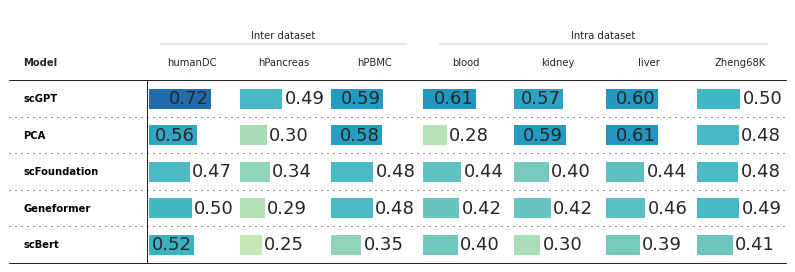

In [44]:
plot_results_table(plot_df, save_path='./fig3_cell_emb_aws_table.svg')

# umap

In [47]:
import os
import pickle


models = ['PCA', 'scBert', 'Geneformer', 'scGPT', 'scFoundation']
datasets = {
            # 'dataset1': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/dataset1/humanDC.h5ad', 
            # 'dataset4': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/dataset4/hPancreas.h5ad', 
            # 'dataset5': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/dataset5/hPBMC.h5ad',
            # 'blood': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/blood.h5ad',
            # 'kidney': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/kidney.h5ad',
            'Zheng68K': '/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/case/data/annotation/human/organs/zheng68k/test.h5ad',
            # 'liver': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/liver.h5ad',
}
pkl_map = {'scBert': 'scbert_cell_emb.pkl', 'scGPT': 'scg_cell_emb.pkl', 'scFoundation': 'scf_cell_emb.pkl', 'Geneformer': 'gf_cell_emb.pkl'}
output_dir = '/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/case/result/zero-shot/cell_emb/int/hvgFalse/'
adata_list = {}
for i in datasets:
    adata = sc.read_h5ad(datasets[i])
    
    label_key = 'celltype' if 'celltype' in adata.obs.columns else 'CellType'
    for model in models:
        print(model)
        if model != 'PCA':
            with open(os.path.join(output_dir, i.split('/')[0], pkl_map[model]), 'rb') as f: 
                adata.obsm[model] = pickle.load(f)
        else:
            sc.pp.highly_variable_genes(adata, subset=True)
            sc.pp.scale(adata)
            sc.pp.pca(adata)
            adata.obsm[model] = adata.obsm['X_pca']
        sc.pp.neighbors(adata, use_rep=model)
        sc.tl.umap(adata)
        adata.obsm[model+"_umap"] = adata.obsm["X_umap"]
        adata_list[i] = adata


PCA


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.resul

scBert
Geneformer
scGPT
scFoundation
PCA


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.resul

scBert
Geneformer
scGPT
scFoundation


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/TSNE.1' was written without encoding metadata.
  return func(*args, **kwargs)
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/TSNE.2' was written without encoding metadata.
  return func(*args, **kwargs)
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/__categories/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/anndata/_io/utils.py:207: OldFormatWarning: Element '/obs/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.

PCA


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.resul

scBert
Geneformer
scGPT
scFoundation
PCA


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.resul

scBert
Geneformer
scGPT
scFoundation


In [49]:
adata_list.keys()

dict_keys(['blood', 'kidney', 'Zheng68K', 'liver'])

/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiup

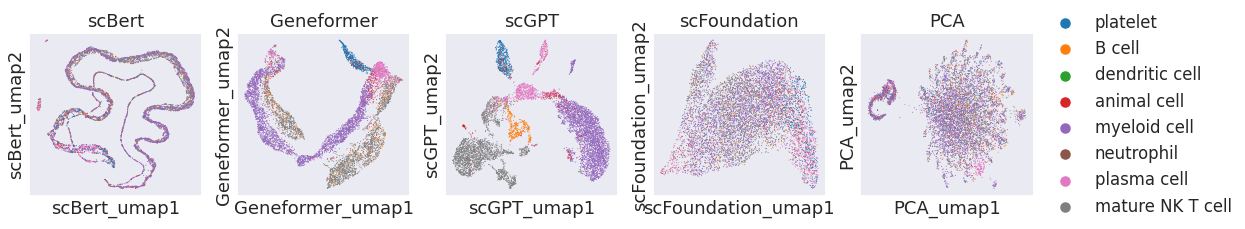

/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiup

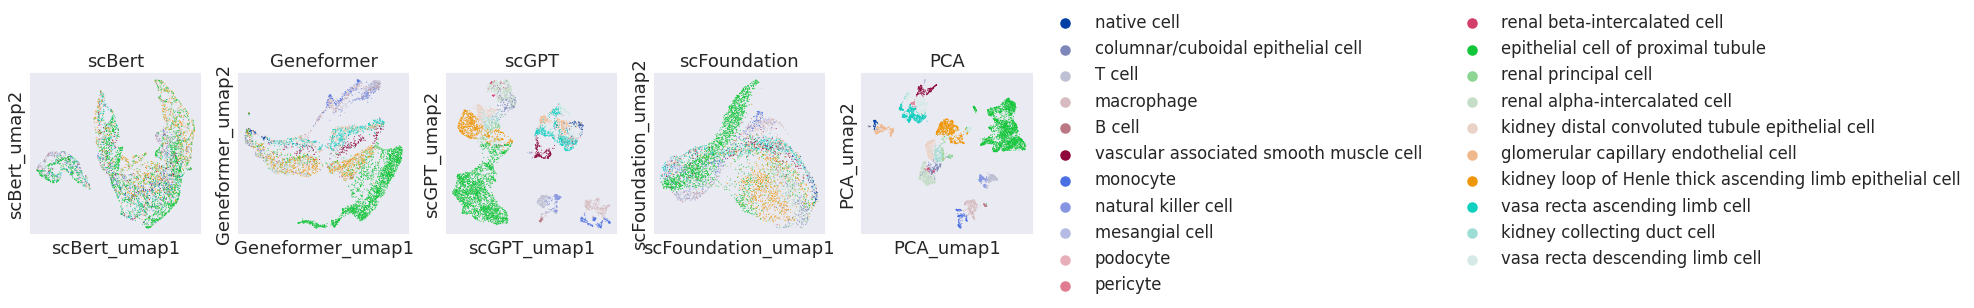

/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiup

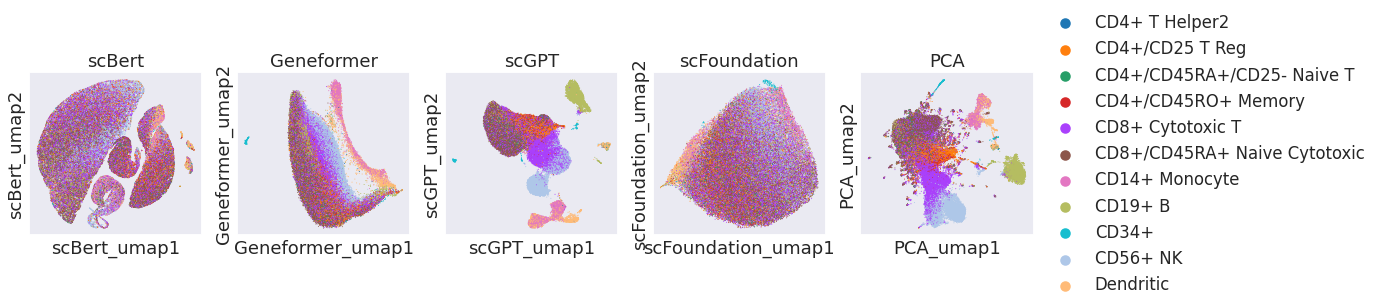

/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiup

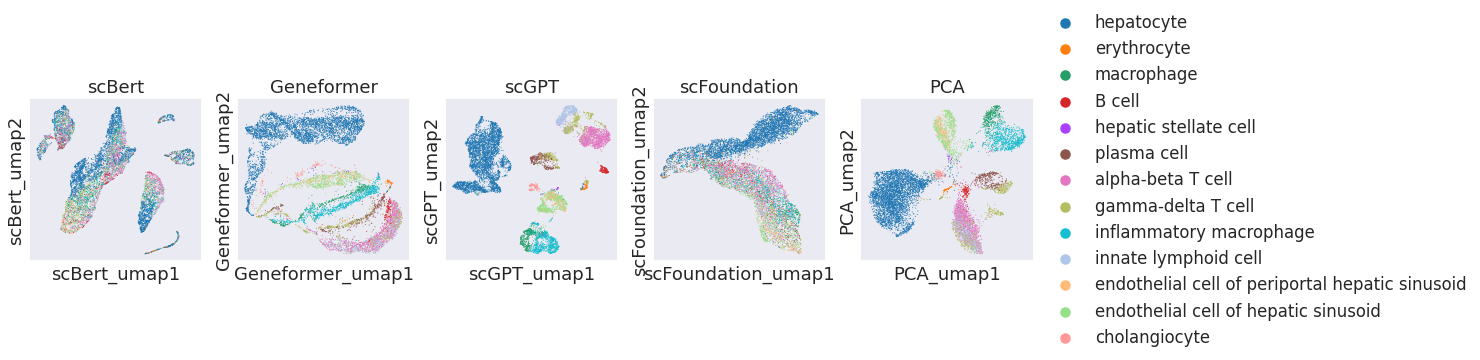

In [48]:
models = ['scBert', 'Geneformer', 'scGPT', 'scFoundation', 'PCA']
for i in adata_list:
    adata = adata_list[i]
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 3), gridspec_kw={"wspace": 0.2})
    label_key = 'celltype' if 'celltype' in adata.obs.columns else 'CellType'
    axes = [ax1, ax2, ax3, ax4, ax5]  # Collect all axes in a list
    for j in range(5):
        ax = axes[j]  # Access the correct ax from the axes list
        if j < 4:
            sc.pl.embedding(adata, basis=models[j]+"_umap", color = label_key, ax=ax, show=False, title=models[j], legend_loc="none", size=4)
        else:
            sc.pl.embedding(adata, basis=models[j]+"_umap", color = label_key, ax=ax, show=False, title=models[j], size=4)
    # Display the plot
    plt.savefig(f"./fig3_cell_emb_{i}.pdf", bbox_inches='tight')
    plt.show()


# hvg effect

In [76]:
import os

scores = defaultdict(list)
models = ['scBert', 'scGPT', 'scFoundation', 'Geneformer']
path = '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/'
output_dir = '/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/case/result/zero-shot/cell_emb/int/hvg'
datasets = {'dataset1': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/dataset1/humanDC.h5ad', 
            'dataset4': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/dataset4/hPancreas.h5ad', 
            'dataset5': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/dataset5/hPBMC.h5ad',
            'blood': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/blood.h5ad',
            'kidney': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/kidney.h5ad',
            'liver': '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/liver.h5ad',}

            # '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/dataset/anno/Zheng68K.h5ad']
dataset_name = {'dataset1': 'humanDC', 'dataset4': 'hPancreas', 'dataset5': 'hPBMC'}
pkl_map = {'scBert': 'scbert_cell_emb.pkl', 'scGPT': 'scg_cell_emb.pkl', 'scFoundation': 'scf_cell_emb.pkl', 'Geneformer': 'gf_cell_emb.pkl'}
hvg_list = [500, 1000, 1500, 2000, 3000]
for i in datasets:
    adata = sc.read_h5ad(datasets[i])
    print(i)
    label_key = 'celltype' if 'celltype' in adata.obs.columns else 'CellType'
    for model in ['PCA', 'scBert', 'scGPT', 'scFoundation', 'Geneformer']:
        
        for hvg in hvg_list:
            if model != 'PCA':
                with open(os.path.join(output_dir + str(hvg), i, pkl_map[model]), 'rb') as f: 
                    adata.obsm['model'] = pickle.load(f)
                    if np.isnan(adata.obsm['model']).sum() > 0:
                        print('cell emb has nan value. ', model, hvg, i)
                        adata.obsm['model'][np.isnan(adata.obsm['model'])] = 0
            else:
                pca_emb = get_pca_emb(adata)
                adata.obsm['model'] = pca_emb
            
            aws = cal_aws(adata.obsm['model'], adata.obs[label_key].cat.codes.values)
            print(model, hvg, aws)
            scores['data'].append(datasets[i].split('/')[-1].split('.h5ad')[0])
            scores['model'].append(model)
            scores['hvg'].append(hvg)
            scores['aws'].append(aws)

dataset1
PCA 500 0.5584579035639763
PCA 1000 0.5584579035639763
PCA 1500 0.5584579035639763
PCA 2000 0.5584579035639763
PCA 3000 0.5584579035639763
scBert 500 0.5072150379419327
scBert 1000 0.5087218647822738
scBert 1500 0.510890337638557
scBert 2000 0.5130166579037905
scBert 3000 0.5150987468659878
scGPT 500 0.5697596222162247
scGPT 1000 0.5867169424891472
scGPT 1500 0.5998426377773285
scGPT 2000 0.6209796816110611
scGPT 3000 0.622105561196804
scFoundation 500 0.5065052872523665
scFoundation 1000 0.5056776865385473
scFoundation 1500 0.5005430252058432
scFoundation 2000 0.49575189920142293
scFoundation 3000 0.4934310591779649
Geneformer 500 0.4954900611191988
Geneformer 1000 0.49168809596449137
Geneformer 1500 0.4948096205480397
Geneformer 2000 0.4974570358172059
Geneformer 3000 0.4963100180029869
dataset4
PCA 500 0.3047562837600708
PCA 1000 0.3047562837600708
PCA 1500 0.3047562837600708
PCA 2000 0.3047562837600708
PCA 3000 0.3047562837600708
scBert 500 0.23209363222122192
scBert 1000 

/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.resul

PCA 500 0.2777838557958603
PCA 1000 0.2777838557958603
PCA 1500 0.2777838557958603
PCA 2000 0.2777838557958603
PCA 3000 0.2777838557958603
scBert 500 0.34580065310001373
scBert 1000 0.3342106342315674
scBert 1500 0.33550944924354553
scBert 2000 0.33690060675144196
scBert 3000 0.3402400463819504
scGPT 500 0.47736563347280025
scGPT 1000 0.5008152368245646
scGPT 1500 0.502246622228995
scGPT 2000 0.5246580801904202
scGPT 3000 0.5264110267162323
scFoundation 500 0.44968466088175774
scFoundation 1000 0.4379598833620548
scFoundation 1500 0.42152218520641327
scFoundation 2000 0.402254194021225
scFoundation 3000 0.3918019235134125
cell emb has nan value.  Geneformer 500 blood
Geneformer 500 0.4578625448048115
cell emb has nan value.  Geneformer 1000 blood
Geneformer 1000 0.4606917090713978
Geneformer 1500 0.475962458178401
Geneformer 2000 0.4713337607681751
Geneformer 3000 0.4772437233477831
kidney


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.resul

PCA 500 0.5902285203337669
PCA 1000 0.5902285203337669
PCA 1500 0.5902285203337669
PCA 2000 0.5902285203337669
PCA 3000 0.5902285203337669
scBert 500 0.4239986464381218
scBert 1000 0.38797272741794586
scBert 1500 0.38564642518758774
scBert 2000 0.37291020154953003
scBert 3000 0.35384616255760193
scGPT 500 0.5127218579873443
scGPT 1000 0.5346867702901363
scGPT 1500 0.5389774069190025
scGPT 2000 0.5484197437763214
scGPT 3000 0.55391775816679
scFoundation 500 0.5185184292495251
scFoundation 1000 0.5033172187395394
scFoundation 1500 0.4909101231023669
scFoundation 2000 0.4833936095237732
scFoundation 3000 0.48044623993337154
Geneformer 500 0.49779188609682024
Geneformer 1000 0.4975746648851782
Geneformer 1500 0.4895605407655239
Geneformer 2000 0.48813052382320166
Geneformer 3000 0.49403798021376133
liver
PCA 500 0.605553887784481
PCA 1000 0.605553887784481
PCA 1500 0.605553887784481
PCA 2000 0.605553887784481
PCA 3000 0.605553887784481
scBert 500 0.3404860198497772
scBert 1000 0.3485381603

In [77]:
df = pd.DataFrame(scores)
df.to_csv('./zero-shot_cellemb_hvg.csv', index=False)

In [78]:
import pandas as pd

df = pd.read_csv('./zero-shot_cellemb_hvg.csv', header=0)
df

,data,model,hvg,aws
0,humanDC,PCA,500,0.558458
1,humanDC,PCA,1000,0.558458
2,humanDC,PCA,1500,0.558458
3,humanDC,PCA,2000,0.558458
4,humanDC,PCA,3000,0.558458
...,...,...,...,...
145,liver,Geneformer,500,0.467881
146,liver,Geneformer,1000,0.473753
147,liver,Geneformer,1500,0.474787
148,liver,Geneformer,2000,0.477826


In [ ]:
from collections import  defaultdict
import matplotlib.pyplot as plt
import numpy as np


data  = defaultdict(list)
group_df = df.groupby(['model', 'hvg'])
for (model, hvg), sub_df in group_df:
    print(model, hvg)
    data[model].append(list(sub_df['aws'].values))
print(data)

In [37]:
len(data['PCA'])

5

([<matplotlib.axis.XTick at 0x4002194b82b0>,
 [Text(1.75, 0, '500'),
  Text(6.75, 0, '1000'),
  Text(11.75, 0, '1500'),
  Text(16.75, 0, '2000'),
  Text(21.75, 0, '3000')])

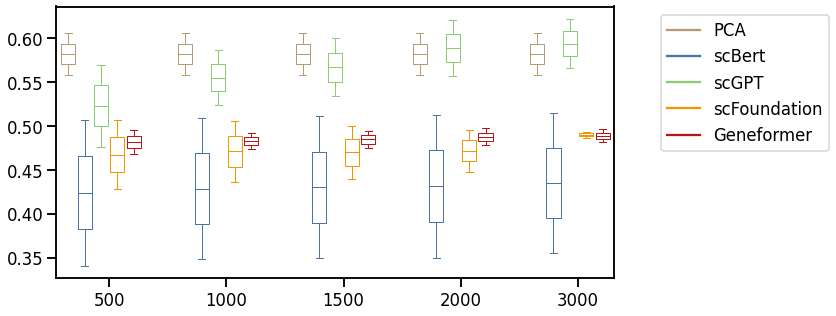

In [53]:
ticks = [str(i) for i in hvg_list]
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(10, 5))
box_gap = 0.7
models = ['PCA', 'scBert', 'scGPT', 'scFoundation', 'Geneformer']
model_color = {"scBert": "#4974a4", "scGPT": "#8acc72", "Geneformer": "#b81316", "scFoundation": "#f29600", 'PCA': '#b79973'}
for i in range(len(models)):
    model = models[i]
    x = data[model]
    bpl = plt.boxplot(x, positions=np.array(range(len(x)))*5.0+box_gap*i, sym='', widths=0.6)
    set_box_color(bpl, model_color[model])
    plt.plot([], c=model_color[model], label=model)
plt.legend(loc=1, bbox_to_anchor=(1.35, 1))

plt.xticks([i + box_gap*2.5 for i in range(0, len(ticks) * 5, 5)], ticks)


In [54]:
df

,data,model,hvg,aws
0,humanDC,PCA,500,0.558458
1,humanDC,PCA,1000,0.558458
2,humanDC,PCA,1500,0.558458
3,humanDC,PCA,2000,0.558458
4,humanDC,PCA,3000,0.558458
5,humanDC,scBert,500,0.507215
6,humanDC,scBert,1000,0.508722
7,humanDC,scBert,1500,0.510890
8,humanDC,scBert,2000,0.513017
9,humanDC,scBert,3000,0.515099


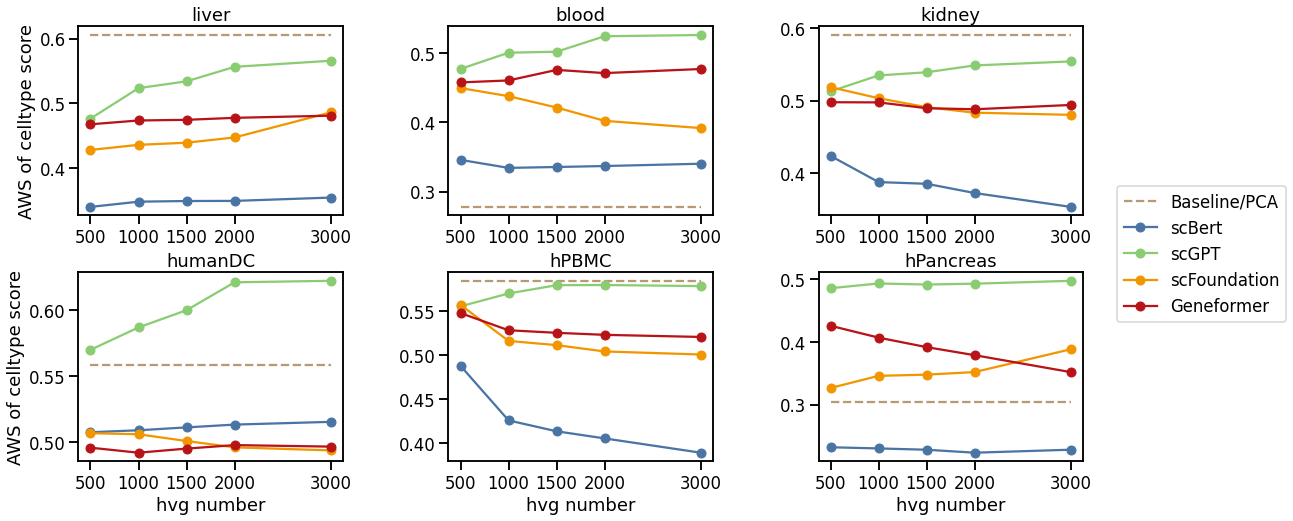

In [88]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8), gridspec_kw={"wspace": 0.4, 'hspace': 0.3})

names = ['liver', 'blood', 'kidney', 'humanDC', 'hPBMC', 'hPancreas']
models = ['PCA', 'scBert', 'scGPT', 'scFoundation', 'Geneformer']
for i in range(len(names)):
    row =  0 if i < 3 else 1
    col = i if i < 3 else i-3
    ax = axes[row][col]
    plot_df = df[df['data'] == names[i]]
    for model in models:
        tmp_df = plot_df[plot_df['model'] == model].sort_values(by='hvg')
        if model == 'PCA':
            ax.plot(tmp_df['hvg'], tmp_df['aws'], marker=None, color=model_color[model], linestyle='--')
        else:
            ax.plot(tmp_df['hvg'], tmp_df['aws'], marker='o', color=model_color[model]) 
    ax.set_xticks(hvg_list)
    ax.set_title(names[i])
    if row == 1:
        ax.set_xlabel('hvg number')
    if col == 0:
        ax.set_ylabel('AWS of celltype score')
    # ax.set_ylim(0, 1)

plt.legend(['Baseline/PCA', 'scBert', 'scGPT', 'scFoundation', 'Geneformer'], loc=1, bbox_to_anchor=(1.8, 1.5))
plt.savefig('./zero-shot_cellemb_hvg.pdf', bbox_inches='tight')

# integrate

In [49]:
import os

scores = defaultdict(list)
models = ['scBert', 'scGPT', 'scFoundation', 'Geneformer']
path = '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/'
output_dir = '/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/case/result/zero-shot/cell_emb/int/'
datasets = ['dataset1/humanDC.h5ad', 'dataset4/hPancreas.h5ad', 'dataset5/hPBMC.h5ad']
dataset_name = {'dataset1': 'humanDC', 'dataset4': 'hPancreas', 'dataset5': 'hPBMC'}
pkl_map = {'scBert': 'scbert_cell_emb.pkl', 'scGPT': 'scg_cell_emb.pkl', 'scFoundation': 'scf_cell_emb.pkl', 'Geneformer': 'gf_cell_emb.pkl'}

for i in datasets:
    adata = sc.read_h5ad(path + i)
    
    label_key = 'celltype' if 'celltype' in adata.obs.columns else 'CellType'
    for model in ['PCA', 'scBert', 'scGPT', 'scFoundation', 'Geneformer']:
        print(model)
        if model != 'PCA':
            with open(os.path.join(output_dir, i.split('/')[0], pkl_map[model]), 'rb') as f: 
                adata.obsm['model'] = pickle.load(f)
                emb_key = 'model'
        else:
            emb_key = 'X_pca'
        res = eval_scib_metrics(adata, batch_key = "batch", label_key = label_key, embed_key  = emb_key)
        scores['data'].append(dataset_name[i.split('/')[0]])
        scores['model'].append(model)
        for score in res:
            scores[score].append(res[score])


PCA


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.782069
ARI_cluster/label          0.818780
ASW_label                  0.558458
ASW_label/batch            0.895487
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.5585, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.8955, graph connectivity: nan, graph iLISI: nan
scBert


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.782069
ARI_cluster/label          0.818780
ASW_label                  0.517797
ASW_label/batch            0.811545
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.5178, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.8115, graph connectivity: nan, graph iLISI: nan
scGPT


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.782069
ARI_cluster/label          0.818780
ASW_label                  0.718301
ASW_label/batch            0.802089
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.7183, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.8021, graph connectivity: nan, graph iLISI: nan
scFoundation


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.782069
ARI_cluster/label          0.818780
ASW_label                  0.473598
ASW_label/batch            0.731726
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.4736, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.7317, graph connectivity: nan, graph iLISI: nan
Geneformer


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.782069
ARI_cluster/label          0.818780
ASW_label                  0.495974
ASW_label/batch            0.918726
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.4960, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.9187, graph connectivity: nan, graph iLISI: nan
PCA


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.644496
ARI_cluster/label          0.440330
ASW_label                  0.304756
ASW_label/batch            0.333413
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.3048, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.3334, graph connectivity: nan, graph iLISI: nan
scBert


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.644496
ARI_cluster/label          0.440330
ASW_label                  0.250732
ASW_label/batch            0.377800
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.2507, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.3778, graph connectivity: nan, graph iLISI: nan
scGPT


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.644496
ARI_cluster/label          0.440330
ASW_label                  0.487144
ASW_label/batch            0.566172
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.4871, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.5662, graph connectivity: nan, graph iLISI: nan
scFoundation


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.644496
ARI_cluster/label          0.440330
ASW_label                  0.344618
ASW_label/batch            0.618909
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.3446, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.6189, graph connectivity: nan, graph iLISI: nan
Geneformer


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.644496
ARI_cluster/label          0.440330
ASW_label                  0.285738
ASW_label/batch            0.486101
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.2857, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.4861, graph connectivity: nan, graph iLISI: nan
PCA


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.661560
ARI_cluster/label          0.376062
ASW_label                  0.584205
ASW_label/batch            0.681296
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.5842, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.6813, graph connectivity: nan, graph iLISI: nan
scBert


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.661560
ARI_cluster/label          0.376062
ASW_label                  0.345286
ASW_label/batch            0.829535
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.3453, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.8295, graph connectivity: nan, graph iLISI: nan
scGPT


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.661560
ARI_cluster/label          0.376062
ASW_label                  0.593002
ASW_label/batch            0.769753
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.5930, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.7698, graph connectivity: nan, graph iLISI: nan
scFoundation


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.661560
ARI_cluster/label          0.376062
ASW_label                  0.480050
ASW_label/batch            0.902137
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.4801, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.9021, graph connectivity: nan, graph iLISI: nan
Geneformer


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
                                  0
NMI_cluster/label          0.661560
ARI_cluster/label          0.376062
ASW_label                  0.478581
ASW_label/batch            0.823835
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
Biological Conservation Metrics: 
ASW (cell-type): 0.4786, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: nan, ASW (batch): 0.8238, graph connectivity: nan, graph iLISI: nan


In [50]:
import pandas as pd

aws_df = pd.DataFrame(scores)
aws_df

,data,model,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,avg_bio
0,humanDC,PCA,0.782069,0.818780,0.558458,0.895487,0.719769
1,humanDC,scBert,0.782069,0.818780,0.517797,0.811545,0.706215
2,humanDC,scGPT,0.782069,0.818780,0.718301,0.802089,0.773050
3,humanDC,scFoundation,0.782069,0.818780,0.473598,0.731726,0.691482
4,humanDC,Geneformer,0.782069,0.818780,0.495974,0.918726,0.698941
5,hPancreas,PCA,0.644496,0.440330,0.304756,0.333413,0.463194
6,hPancreas,scBert,0.644496,0.440330,0.250732,0.377800,0.445186
7,hPancreas,scGPT,0.644496,0.440330,0.487144,0.566172,0.523990
8,hPancreas,scFoundation,0.644496,0.440330,0.344618,0.618909,0.476481
9,hPancreas,Geneformer,0.644496,0.440330,0.285738,0.486101,0.456855


In [116]:
df

,model,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,avg_bio
data,,,,,,
humanDC,PCA,0.782069,0.818780,0.558458,0.895487,0.719769
humanDC,scBert,0.782069,0.818780,0.517797,0.811545,0.706215
humanDC,scGPT,0.782069,0.818780,0.718301,0.802089,0.773050
humanDC,scFoundation,0.782069,0.818780,0.473598,0.731726,0.691482
humanDC,Geneformer,0.782069,0.818780,0.495974,0.918726,0.698941
hPancreas,PCA,0.644496,0.440330,0.304756,0.333413,0.463194
hPancreas,scBert,0.644496,0.440330,0.250732,0.377800,0.445186
hPancreas,scGPT,0.644496,0.440330,0.487144,0.566172,0.523990
hPancreas,scFoundation,0.644496,0.440330,0.344618,0.618909,0.476481


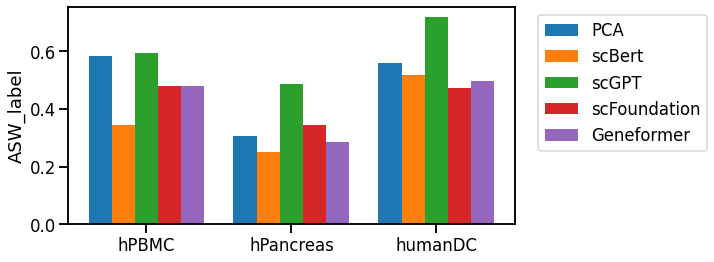

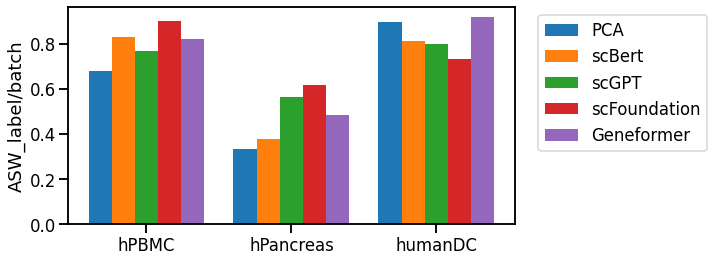

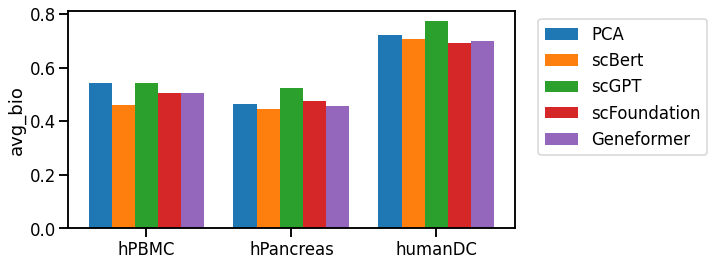

In [117]:
import matplotlib.pyplot as plt
import numpy as np

def creat_multi_bars(labels, datas, ylabel, legend, tick_step=1, group_gap=0.2, bar_gap=0):
    fig = plt.figure(figsize=(8, 4))
    x= np.arange(len(labels)) * tick_step
    group_num = len(datas)
    group_width = tick_step - group_gap
    bar_span = group_width / group_num
    bar_width = bar_span - bar_gap
    for index, y in enumerate(datas):
        plt.bar(x + index*bar_span, y , bar_width)
    plt.ylabel(ylabel)
    ticks = x + (group_width-bar_span) / 2
    plt.xticks(ticks, labels)
    # plt.legend(loc='upper center', bbox_to_anchor=())
    plt.legend(legend, loc=1, bbox_to_anchor=(1.45, 1))
    # plt.show()
    return fig

labels = list(np.unique(aws_df['data']))
models = ['PCA', 'scBert', 'scGPT', 'scFoundation', 'Geneformer']

df = aws_df.set_index('data')
colunms = [ 'ASW_label', 'ASW_label/batch', 'avg_bio']
for col in colunms:
    datas = []
    for m in models:
        data = df[df.model == m].loc[labels][col].values
        datas.append(data)

    fig = creat_multi_bars(labels, datas, col, models)
    plt.savefig(f'./fig3_{col.replace("/", "_")}_bar.pdf', bbox_inches='tight')

In [119]:
df

,model,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,avg_bio
data,,,,,,
humanDC,PCA,0.782069,0.818780,0.558458,0.895487,0.719769
humanDC,scBert,0.782069,0.818780,0.517797,0.811545,0.706215
humanDC,scGPT,0.782069,0.818780,0.718301,0.802089,0.773050
humanDC,scFoundation,0.782069,0.818780,0.473598,0.731726,0.691482
humanDC,Geneformer,0.782069,0.818780,0.495974,0.918726,0.698941
hPancreas,PCA,0.644496,0.440330,0.304756,0.333413,0.463194
hPancreas,scBert,0.644496,0.440330,0.250732,0.377800,0.445186
hPancreas,scGPT,0.644496,0.440330,0.487144,0.566172,0.523990
hPancreas,scFoundation,0.644496,0.440330,0.344618,0.618909,0.476481


In [125]:
df.loc[data_names[i]]

,model,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,avg_bio
data,,,,,,
hPBMC,PCA,0.66156,0.376062,0.584205,0.681296,0.540609
hPBMC,scBert,0.66156,0.376062,0.345286,0.829535,0.460970
hPBMC,scGPT,0.66156,0.376062,0.593002,0.769753,0.543541
hPBMC,scFoundation,0.66156,0.376062,0.480050,0.902137,0.505891
hPBMC,Geneformer,0.66156,0.376062,0.478581,0.823835,0.505401


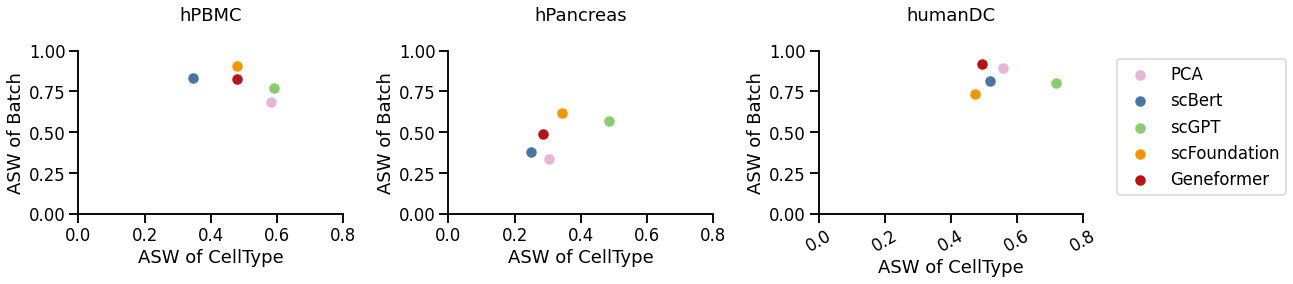

In [178]:
model_color = {"scBert": "#4974a4", "scGPT": "#8acc72", "Geneformer": "#b81316", "scFoundation": "#f29600", 'PCA': "#e4b7d6"}
fig, axes = plt.subplots(1, 3, figsize=(18, 3), gridspec_kw={"wspace": 0.4})
# plt.subplots_adjust(wspace=0.4, hspace=0)
data_names = np.unique(df.index.values)
for i in range(len(data_names)):
    x = df.loc[data_names[i]]['ASW_label'].values # 'ASW_label', 'ASW_label/batch'
    y = df.loc[data_names[i]]['ASW_label/batch'].values # 'ASW_label', 'ASW_label/batch'
    # s = [int((x[i] + y[i]) * 10) for i in range(len(x))]
    ax = axes[i]
    colors = [model_color[i] for i in df.loc[data_names[i]]['model']]
    for j in range(len(x)):
        ax.scatter(x[j], y[j], c=colors[j], label=df.loc[data_names[i]]['model'][j])
    
    # for j in range(5):
    #     ax.annotate(df.loc[data_names[i]]['model'][j], xy = (x[j], y[j]), xytext=(x[j]-0.015, y[j]+0.01))
    plt.xticks(rotation=30)
    ax.set_xlabel('ASW of CellType')
    ax.set_ylabel('ASW of Batch')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(data_names[i], loc='center', pad=30)
    ax.set_xlim(0, 0.8)
    ax.set_ylim(0, 1)
plt.legend(loc=1, bbox_to_anchor=(1.8, 1))
plt.savefig(f"./fig3_scatter_aws.pdf", bbox_inches='tight')


# umap of integrate 

In [3]:
import os
import pickle
import scanpy as sc


models = ['PCA', 'scBert', 'Geneformer', 'scGPT', 'scFoundation']
path = '/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/'
output_dir = '/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/case/result/zero-shot/cell_emb/int/hvg2000'
datasets = ['dataset1/humanDC.h5ad', 'dataset4/hPancreas.h5ad', 'dataset5/hPBMC.h5ad']
dataset_name = {'dataset1': 'humanDC', 'dataset4': 'hPancreas', 'dataset5': 'hPBMC'}
pkl_map = {'scBert': 'scbert_cell_emb.pkl', 'scGPT': 'scg_cell_emb.pkl', 'scFoundation': 'scf_cell_emb.pkl', 'Geneformer': 'gf_cell_emb.pkl'}

adata_list = {}
for i in datasets:
    adata = sc.read_h5ad(path + i)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
    label_key = 'celltype' if 'celltype' in adata.obs.columns else 'CellType'
    for model in models:
        print(model)
        if model != 'PCA':
            with open(os.path.join(output_dir, i.split('/')[0], pkl_map[model]), 'rb') as f: 
                adata.obsm[model] = pickle.load(f)
        else:
            adata.obsm[model] = adata.obsm['X_pca']
        sc.pp.neighbors(adata, use_rep=model)
        sc.tl.umap(adata)
        adata.obsm[model+"_umap"] = adata.obsm["X_umap"]
        adata_list[i] = adata


PCA
scBert
Geneformer
scGPT
scFoundation
PCA
scBert
Geneformer
scGPT
scFoundation
PCA
scBert
Geneformer
scGPT
scFoundation


In [9]:
from collections import  defaultdict

celltype_aws = defaultdict(dict)
batch_aws = defaultdict(dict)
for i in adata_list:
    

{'dataset1/humanDC.h5ad': AnnData object with n_obs × n_vars = 576 × 2000
     obs: 'cell', 'celltype', 'batch', 'batch_str'
     var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'log1p', 'pca', 'hvg', 'neighbors', 'umap', 'celltype_colors', 'batch_str_colors'
     obsm: 'X_pca', 'PCA', 'X_umap', 'PCA_umap', 'scBert', 'scBert_umap', 'Geneformer', 'Geneformer_umap', 'scGPT', 'scGPT_umap', 'scFoundation', 'scFoundation_umap'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 'dataset4/hPancreas.h5ad': AnnData object with n_obs × n_vars = 14767 × 2000
     obs: 'batch', 'batchlb', 'celltype_orig', 'cellname', 'celltype', 'batch_str'
     var: 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'log1p', 'pca', 'hvg', 'neighbors', 'umap', 'celltype_colors', 'batch_str_colors'
     obsm: 'X_pca', 'PCA', 'X_umap', 'PCA_umap', 'scBert', 'scBert_umap', 'Geneformer', 'Geneformer_umap', 'scGPT', 'scGPT_umap', '

/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiup

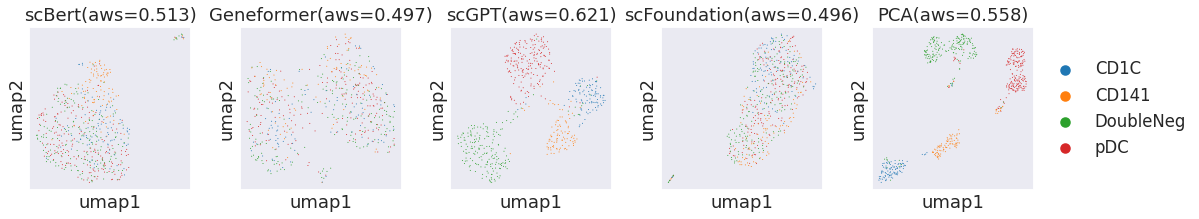

/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiup

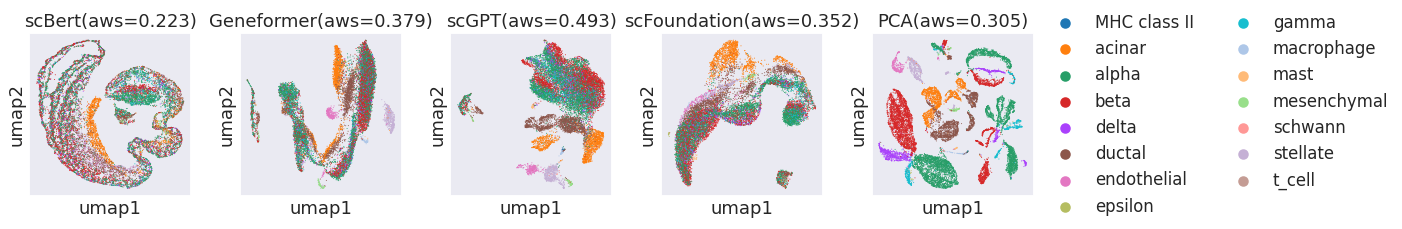

/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiup

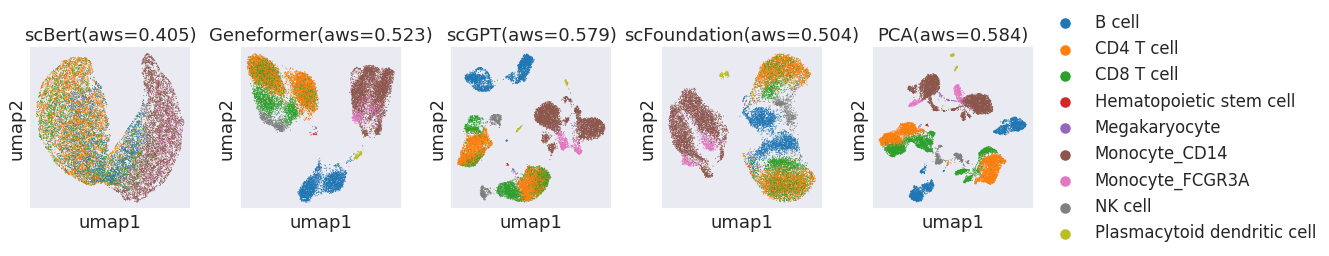

In [14]:
from matplotlib import pyplot as plt


models = ['scBert', 'Geneformer', 'scGPT', 'scFoundation', 'PCA']
for i in adata_list:
    aws_score = {}
    adata = adata_list[i]
    label_key = 'celltype' if 'celltype' in adata.obs.columns else 'CellType'
    for m in models:
        aws = cal_aws(adata.obsm[m], adata.obs[label_key].cat.codes)
        aws_score[m] = aws
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 3), gridspec_kw={"wspace": 0.3})
    
    adata.obs['batch_str'] = adata.obs['batch'].astype(str)
    # label_key = 'batch_str'
    axes = [ax1, ax2, ax3, ax4, ax5]  # Collect all axes in a list
    for j in range(5):
        ax = axes[j]  # Access the correct ax from the axes list
        title = f'{models[j]}(aws={aws_score[models[j]]:.3f})'
        if j < 4:
            sc.pl.embedding(adata, basis=models[j]+"_umap", color = label_key, ax=ax, show=False, title=title, legend_loc="none", size=4)
        else:
            sc.pl.embedding(adata, basis=models[j]+"_umap", color = label_key, ax=ax, show=False, title=title, size=4)
        ax.set_xlabel('umap1')
        ax.set_ylabel('umap2')
    # Display the plot
    plt.savefig(f"./fig3_cell_emb_{i.split('/')[0]}_celltype.pdf", bbox_inches='tight')
    plt.show()


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiup

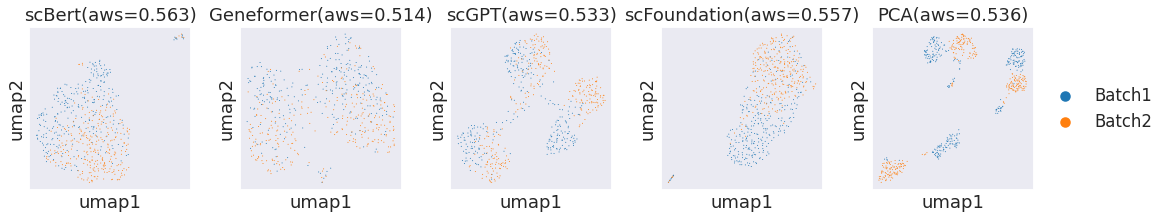

/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiup

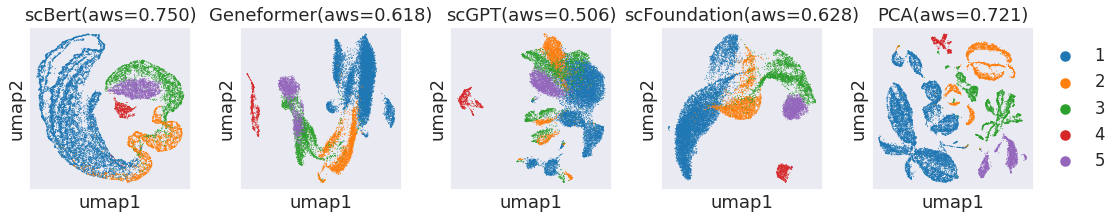

/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_qiup

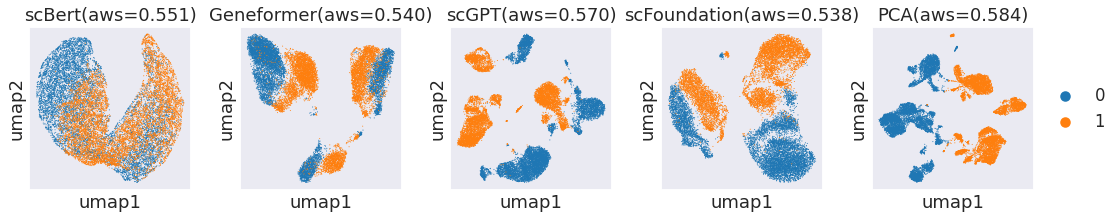

In [18]:
import pandas as pd


models = ['scBert', 'Geneformer', 'scGPT', 'scFoundation', 'PCA']
for i in adata_list:
    aws_score = {}
    adata = adata_list[i]
    adata.obs['batch_str'] = pd.Categorical(adata.obs['batch'].astype(str))
    label_key = 'batch_str'
    for m in models:
        aws = cal_aws(adata.obsm[m], adata.obs[label_key].cat.codes)
        aws_score[m] = aws
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 3), gridspec_kw={"wspace": 0.3})
    
    
    axes = [ax1, ax2, ax3, ax4, ax5]  # Collect all axes in a list
    for j in range(5):
        ax = axes[j]  # Access the correct ax from the axes list
        title = f'{models[j]}(aws={aws_score[models[j]]:.3f})'
        if j < 4:
            sc.pl.embedding(adata, basis=models[j]+"_umap", color = label_key, ax=ax, show=False, title=title, legend_loc="none", size=4)
        else:
            sc.pl.embedding(adata, basis=models[j]+"_umap", color = label_key, ax=ax, show=False, title=title, size=4)
        ax.set_xlabel('umap1')
        ax.set_ylabel('umap2')
    # Display the plot
    plt.savefig(f"./fig3_cell_emb_{i.split('/')[0]}_batch.pdf", bbox_inches='tight')
    plt.show()